#We are going to work on a computer vision project aimed at detecting and localizing license plates of cars. To do this, we will use the provided dataset and create an end-to-end project. Good luck!

#The entire project will be done on Google Colab

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to the zip file
zip_file_path = '/content/drive/MyDrive/ColabNotebooks/number_plate-2.zip'  # Update this with your actual file path

# Set the directory where you want to extract the contents
extracted_path = '/content/drive/MyDrive/ColabNotebooks'  # Update this with your desired extraction path

# Create the extraction folder if it doesn't exist
!mkdir -p $extracted_path

# Unzip the file
!unzip -q $zip_file_path -d $extracted_path

print(f"Successfully extracted files to {extracted_path}")


Successfully extracted files to /content/drive/MyDrive/ColabNotebooks


In [ ]:
#/content/drive/MyDrive/ColabNotebooks/number_plate-2
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1- DATA PROCESSING AND CREATING THE DATAFRAME

#### 1.1 - Count the number of files in image directory and determine their file types.

In [ ]:
#import face_recognition
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

In [ ]:
path= '/content/drive/MyDrive/ColabNotebooks/number_plate-2/images'
file_list = os.listdir(path)
print(file_list[1])
print(file_list[13])
print(len(file_list))

N95.jpeg
N77.xml
450


In [ ]:
#228 .jpeg et 225 .xml

####1.2 - Count the number of xml files and jpeg files

In [ ]:
import glob
xml_list = glob.glob('/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/*.xml')
jpeg_list= glob.glob('/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/*.jpeg')

len(xml_list), len(jpeg_list)

(225, 225)

####You may now notice that there are more images than associated XML files. What are these images? Delete them from the "image" directory. (with code)

In [ ]:
#need to check if for every xml num there is the equivalent in jpeg


jpeg_files = [file for file in file_list if file.lower().endswith(".jpeg")]

for jpeg_file in jpeg_files:
    xml_file = os.path.splitext(jpeg_file)[0] + ".xml"
    if xml_file not in file_list:
        # Construct the full paths for deletion
        jpeg_noxml_path = os.path.join(path, jpeg_file)
        print(jpeg_noxml_path)




/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/N180.jpeg
/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/N249.jpeg
/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/N182.jpeg


In [ ]:
os.remove('/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/N249.jpeg')
os.remove('/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/N180.jpeg')
os.remove('/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/N182.jpeg')


In [ ]:
xml_list = glob.glob('/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/*.xml')
jpeg_list= glob.glob('/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/*.jpeg')
len(xml_list), len(jpeg_list)

(225, 225)

#### We can now see that we have one XML file per image. In each file, we have the file path of the image, the name of the object to be detected, the width and height of the image, and the coordinates (in the format xmin, xmax, ymin, ymax) of the bounding box that surrounds the license plat

####  We will now read the XML files and store the information in a dataframe. We want to create a dataframe that contains the file path of the image, the object to be detected, the image shape, and the bounding box of the object. There are many options available to parse an XML file, but we recommend using Beautiful Soup, which you have already seen earlier in your journey.

#### 1.3 - Create a dataframe with 8 columns (and number of lines = number of images).  
The columns are :  

1.   filepath_img
2.   name_object
3.   height_img
4.   width_img
5.   xmin
6.   xmax
7.   ymin
8.   ymax

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

In [ ]:
data = []

for xml_file in os.listdir(path):
    if xml_file.lower().endswith(".xml"):
        xml_file_path = os.path.join(path, xml_file)

        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        filename = root.find("filename").text
        width = int(root.find("size/width").text)
        height = int(root.find("size/height").text)
        xmin = int(root.find("object/bndbox/xmin").text)
        xmax = int(root.find("object/bndbox/xmax").text)
        ymin = int(root.find("object/bndbox/ymin").text)
        ymax = int(root.find("object/bndbox/ymax").text)

        img_file_path = os.path.join(path, filename)

        # Append data to the list
        data.append({
            'filepath_img': img_file_path,
            'name_object': root.find("object/name").text,
            'height_img': height,
            'width_img': width,
            'xmin': xmin,
            'xmax': xmax,
            'ymin': ymin,
            'ymax': ymax
        })

df = pd.DataFrame(data)

df.head()

,filepath_img,name_object,height_img,width_img,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/ColabNotebooks/number_p...,number_plate,363,441,207,356,174,287
1,/content/drive/MyDrive/ColabNotebooks/number_p...,number_plate,300,400,39,108,129,157
2,/content/drive/MyDrive/ColabNotebooks/number_p...,number_plate,269,500,289,421,188,232
3,/content/drive/MyDrive/ColabNotebooks/number_p...,number_plate,393,500,150,378,217,269
4,/content/drive/MyDrive/ColabNotebooks/number_p...,number_plate,338,610,208,370,89,173


In [ ]:
new_csv_path = "/content/drive/MyDrive/ColabNotebooks/number_plate-2/xml_info.csv"
df.to_csv(new_csv_path, index=False)

#### 1.4 - We will create 4 different target variables:

1. Xmoy, which represents the x-coordinate of the center of the bounding box.
2. Ymoy, which represents the y-coordinate of the center of the bounding box.
3. W, the width of the bounding box.
4. H, the height of the bounding box.

Furthermore, we will normalize these values with respect to the image shape.

Later on, we can delete the "name_object" column since there is only one object to be detected per image and the xmin, xmax, ymin, ymax columns.

1.   Create the features xmoy,ymoy,w,h
2.   Normalize this features by the height and width of the image
3. drop xmin,xmax,ymin,ymax in the dataframe


In [ ]:
df['Xmoy'] = ((df['xmin'] + df['xmax']) / 2)/df['width_img']
df['Ymoy'] = ((df['ymin'] + df['ymax']) / 2)/df['height_img']
df['W'] = ((df['xmax'] - df['xmin']) )/df['width_img']
df['H'] = ((df['ymax'] - df['ymin']) )/df['height_img']
df.head()

,filepath_img,name_object,height_img,width_img,xmin,xmax,ymin,ymax,Xmoy,Ymoy,W,H
0,/content/drive/MyDrive/ColabNotebooks/number_p...,number_plate,363,441,207,356,174,287,0.638322,0.634986,0.337868,0.311295
1,/content/drive/MyDrive/ColabNotebooks/number_p...,number_plate,300,400,39,108,129,157,0.183750,0.476667,0.172500,0.093333
2,/content/drive/MyDrive/ColabNotebooks/number_p...,number_plate,269,500,289,421,188,232,0.710000,0.780669,0.264000,0.163569
3,/content/drive/MyDrive/ColabNotebooks/number_p...,number_plate,393,500,150,378,217,269,0.528000,0.618321,0.456000,0.132316
4,/content/drive/MyDrive/ColabNotebooks/number_p...,number_plate,338,610,208,370,89,173,0.473770,0.387574,0.265574,0.248521


In [ ]:
df = df.drop(['name_object','xmin', 'xmax', 'ymin', 'ymax'], axis =1)
df.head()

,filepath_img,height_img,width_img,Xmoy,Ymoy,W,H
0,/content/drive/MyDrive/ColabNotebooks/number_p...,363,441,0.638322,0.634986,0.337868,0.311295
1,/content/drive/MyDrive/ColabNotebooks/number_p...,300,400,0.183750,0.476667,0.172500,0.093333
2,/content/drive/MyDrive/ColabNotebooks/number_p...,269,500,0.710000,0.780669,0.264000,0.163569
3,/content/drive/MyDrive/ColabNotebooks/number_p...,393,500,0.528000,0.618321,0.456000,0.132316
4,/content/drive/MyDrive/ColabNotebooks/number_p...,338,610,0.473770,0.387574,0.265574,0.248521


<Axes: xlabel='W', ylabel='H'>

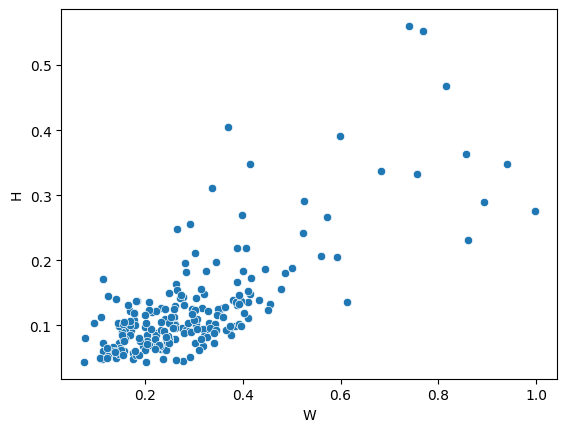

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(data=df, x=df.W, y=df.H)

# 2 - Analyze

##### 2.1 - Analyze the size of the images. Do we have images of small or large size?

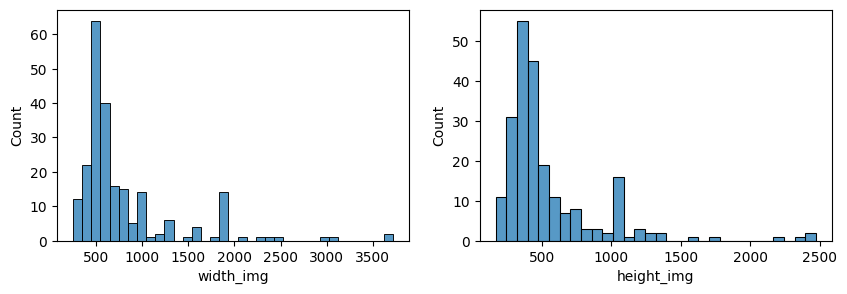

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(121)
sns.histplot(data=df, x=df.width_img, y=None, hue=None ,stat='count')
plt.subplot(122)
sns.histplot(data=df, x=df.height_img, y=None, hue=None ,stat='count')
plt.show()

In [ ]:
# distribution od width and height
# concentrated 500 * 500 pics

##### 2.2- Now Analyze the size of the bbox. where are the plate in the image ? the objet are small or large ?

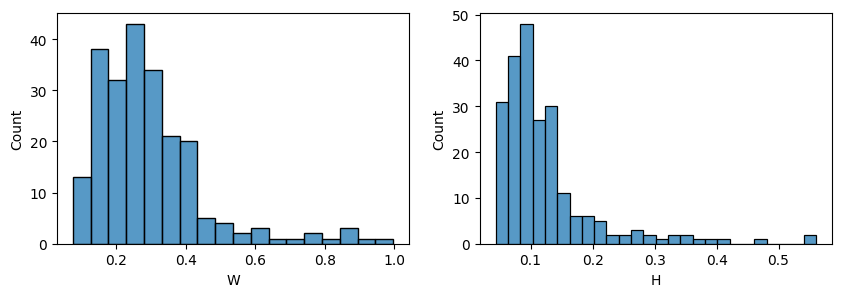

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(121)
sns.histplot(data=df, x=df.W, y=None, hue=None ,stat='count')
plt.subplot(122)
sns.histplot(data=df, x=df.H, y=None, hue=None ,stat='count')
plt.show()

In [ ]:
# distribution of normalized Width and Height of bboxes
# bbox cetralized with plots below

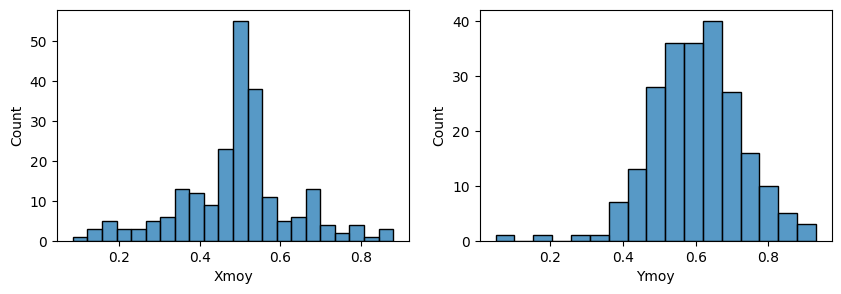

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(121)
sns.histplot(data=df, x=df.Xmoy, y=None, hue=None ,stat='count')
plt.subplot(122)
sns.histplot(data=df, x=df.Ymoy, y=None, hue=None ,stat='count')
plt.show()

<Axes: xlabel='Xmoy', ylabel='Ymoy'>

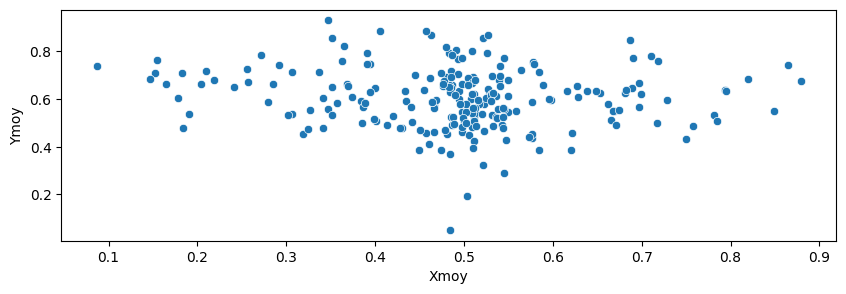

In [ ]:
plt.figure(figsize=(10,3))
#plt.subplot(121)
sns.scatterplot(data=df, x=df.Xmoy, y=df.Ymoy, hue=None)
#plt.subplot(122)
#sns.scatterplot(data=df, x=df.Ymoy, y=None, hue=None ,stat='count')
#plt.show()

##### 2.3- Use the function show_bounding_box to plot some images with their bbox

In [ ]:
#fonction a donner aux étudiants
def show_bounding_box(im, bbox, normalised=True, color='r'):
    # Signification de bbox
    x, y, w, h = bbox
    # Convertir les cordonées (x,y,w,h) en (x1,x2,y1,y2)
    x1=x-w/2
    x2=x+w/2
    y1=y-h/2
    y2=y+h/2

    # Redimentionner en cas de normalisation
    if normalised:
        x1=x1*im.shape[1]
        x2=x2*im.shape[1]
        y1=y1*im.shape[0]
        y2=y2*im.shape[0]

    # Afficher l'image
    plt.imshow(im)

    # Afficher la bounding box
    plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],"r")

In [ ]:
#im = plt.imread(str(df.loc[0, ['filepath_img']]))
im = plt.imread('/content/drive/MyDrive/ColabNotebooks/number_plate-2/images/N107.jpeg')
bbox = df.loc[0,['Xmoy', 'Ymoy', 'W', 'H']]

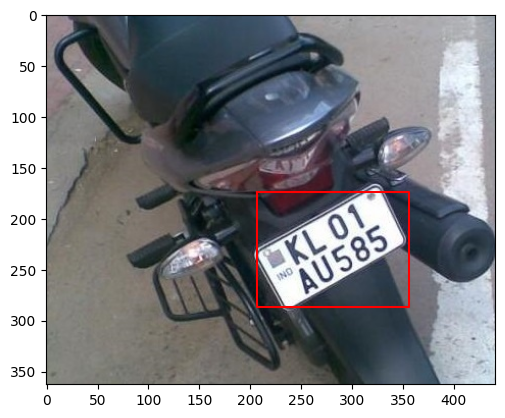

In [ ]:
show_bounding_box(im, bbox, normalised=True, color='r')

#3 - MODELISATION

#### 3.1 - In this section, we will use pre-trained Yolov5 model to predict the coordinates of the bbox
And after we apply a OCR model to detect what is the text on the bbox

In [ ]:
#Apply this code
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16057, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 16057 (delta 0), reused 0 (delta 0), pack-reused 16056
Receiving objects: 100% (16057/16057), 14.66 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (11028/11028), done.


In [ ]:
#and this
!pip install -r ./yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.4/645.4 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.


#### we are going to create 1folder and 2 subfolder


1.   *data_images* folder
2.   in the *data_images* folder we create **data_train** and **data_test**


In [ ]:
#!mkdir yolov5/data_images/
#!mkdir yolov5/data_images/test/
#!mkdir yolov5/data_images/train/

base_directory = '/content/drive/MyDrive/ColabNotebooks/number_plate-2'
prefix = 'yolov5'

base_path = os.path.join(base_directory, prefix)
os.makedirs(base_path, exist_ok=True)

subdirectories = ['data_images', 'data_images/test/', 'data_images/train/']

for subdirectory in subdirectories:
    path = os.path.join(base_path, subdirectory)
    os.makedirs(path, exist_ok=True)

#### split the data on train/test (200 first lines train and the other test) (call df_train and df_test)

In [ ]:
df_train = df.loc[:199]
df_test = df.loc[200:]

In [ ]:
df_train.shape, df_test.shape

((200, 7), (25, 7))

#### Compile this code and understand what it does.

In [ ]:
from shutil import copy
import os
train_folder = './yolov5/data_images/train'

values = df_train[['filepath_img','Xmoy','Ymoy','W','H']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

test_folder = './yolov5/data_images/test'

values = df_test[['filepath_img','Xmoy','Ymoy','W','H']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

#### now we apply the yolov5 model on 100 epochs (not forget to active gpu)

In [ ]:
!python ./yolov5/train.py --data /content/drive/MyDrive/ColabNotebooks/number_plate-2/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

2023-11-17 13:23:19.520460: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 13:23:19.520520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 13:23:19.520570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=/content/drive/MyDrive/ColabNotebooks/number_plate-2/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, de

#### we save and import the weights of the model

In [ ]:
import cv2
!pip install onnx onnxruntime
!pip install opencv-python-headless

!python ./yolov5/export.py --weight ./yolov5/runs/train/Model5/weights/best.pt --include torchscript onnx

net = cv2.dnn.readNetFromONNX('/content/yolov5/runs/train/Model5/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model5/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-241-gb6a65e1 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model5/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 2.1.0+cu118...
TorchScript: export success ✅ 2.2s, saved as yolov5/runs/train/Model5/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.15.0...
ONNX: export success ✅ 1.0s, saved as yolov5/runs/train/Model5/weights/best.onnx (27.2 MB)

Export complete (3.9s)
Results sav

#### Compute the code below

In [ ]:
import numpy as np

INPUT_WIDTH =  640
INPUT_HEIGHT = 640

def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]

    return input_image, detections

def non_maximum_supression(input_image,detections):

    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE

    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.01:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)

    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image


def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]

    if 0 in roi.shape:
        return 'no number'

    else:
        text = pt.image_to_string(roi)
        text = text.strip()

        return text

def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

#### Compute the code below to install tesseract ocr

In [ ]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install pytesseract
import pytesseract as pt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,678 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

#### Read the image test and apply yolo_prediction with the weights of the model

####Plot the result and we finish the project congrats !!

In [ ]:
img1 = plt.imread('/content/drive/MyDrive/ColabNotebooks/number_plate-2/TEST/TEST.jpeg')

In [ ]:
arr_img1 = yolo_predictions(img1,net)

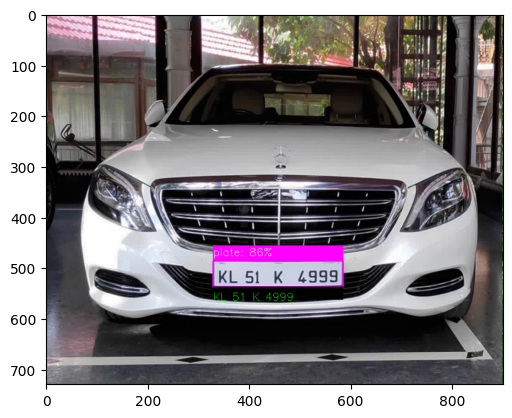

In [ ]:
plt.imshow(arr_img1)

In [ ]:
img1 = plt.imread('/content/drive/MyDrive/ColabNotebooks/number_plate-2/TEST/TEST1.jpeg')
img2 = plt.imread('/content/drive/MyDrive/ColabNotebooks/number_plate-2/TEST/TEST2.png')
img3 = plt.imread('/content/drive/MyDrive/ColabNotebooks/number_plate-2/TEST/TEST3.png')
img4 = plt.imread('/content/drive/MyDrive/ColabNotebooks/number_plate-2/TEST/TEST4.png')
img5 = plt.imread('/content/drive/MyDrive/ColabNotebooks/number_plate-2/TEST/TEST5.png')

In [ ]:
img2.shape

(266, 547, 4)

In [ ]:
arr_img1 = yolo_predictions(img1[:, :, :3],net)
arr_img2 = yolo_predictions(img2[:, :, :3],net)
arr_img3 = yolo_predictions(img3[:, :, :3],net)
arr_img4 = yolo_predictions(img4[:, :, :3],net)
arr_img5 = yolo_predictions(img5[:, :, :3],net)

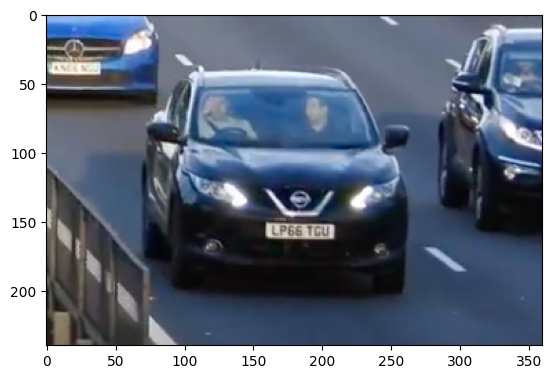

In [ ]:
plt.imshow(arr_img3)